# **Second Project PP (part2)**

Ghadamiyan Lida 407 AI

# Imports

In [1]:
!pip install pymc

In [2]:
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
import tensorflow as tf 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop 
import os
from tensorflow.keras.models import load_model
from pymc3.theanof import MRG_RandomStreams, set_tt_rng

import numpy as np
import math
import pandas as pd 

from sklearn.preprocessing import scale
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

In [4]:
!pip install arviz

# Data Set

In [5]:
iris = datasets.load_iris()
data = iris.data[:, :3] 
labels = iris.target

data = scale(data)
labels = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3, random_state = 42, shuffle = True)

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'X'), Text(0.5, 1.0, 'Iris data set')]

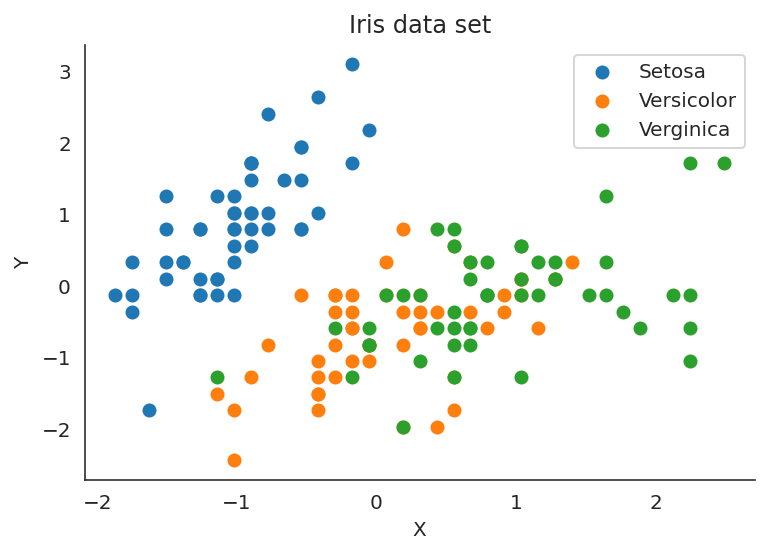

In [6]:
fig, ax = plt.subplots()
ax.scatter(data[labels==0, 0], data[labels==0, 1], label='Setosa')
ax.scatter(data[labels==1, 0], data[labels==1, 1], label='Versicolor')
ax.scatter(data[labels==2, 0], data[labels==2, 1], label='Verginica')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Iris data set')

# Multiclass Bayesian NN

The only difference regarding this part consists in the fact that the arhitecture presents only one hidden layer and the output  is denoted by a Categorical distribution fed with the output of the softmax activation function

In [7]:
# function for building the multiclass bayesian neural network
def build_bbnn(bbnn_input, bbnn_output, nn_input, nn_output, hidden_layers, n_classes):

    with pm.Model() as bneural_network:
        bbnn_input = pm.Data("bbnn_input", bbnn_input)
        bbnn_output = pm.Data("bbnn_output", bbnn_output)

        # Prior on weights and biases 

        # Prior on biases
        biases = pm.Normal('biases', 0, 1, shape = (2, ))

        # Prior on weights from input to the hidden layer
        weights1 = pm.Normal("weights1", 0, 1, shape=(nn_input.shape[1], hidden_layers), 
                            testval = np.random.randn(nn_input.shape[1], hidden_layers)*np.sqrt(2/hidden_layers).astype(floatX))

        # Prior on weights from the first to the second hidden layer
        weights2 = pm.Normal("weights2", 0, 1, shape=(hidden_layers, n_classes), 
                            testval = np.random.randn(hidden_layers, n_classes)*np.sqrt(2/hidden_layers).astype(floatX))

        # Hyperbolic tangent as activation function
        activation1 = pm.math.tanh(pm.math.dot(bbnn_input, weights1) + biases[0])
        activationOut = T.nnet.softmax(pm.math.dot(activation1, weights2) + biases[1])

        # Categorical likelihood for multiclass classification
        likelihood = pm.Categorical('likelihood', activationOut, observed = bbnn_output, total_size = n_classes)
    return bneural_network


In [8]:
bneural_network = build_bbnn(X_train, Y_train, X_train, Y_train, 10, len(list(set(Y_train))))

In [9]:
set_tt_rng(MRG_RandomStreams(42))

with bneural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)
trace = approx.sample(draws=100)

x = T.matrix("X")
n = T.iscalar("n")

x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    bneural_network.likelihood.distribution.p, size=n, more_replacements={bneural_network["bbnn_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba, on_unused_input='ignore')
pred = sample_proba(X_test, 1000).mean(0)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 427.3: 100%|██████████| 10000/10000 [00:12<00:00, 774.59it/s]
Finished [100%]: Average Loss = 427.25


The probability of each class are very similar

In [10]:
print(pred[:7])

[[0.3290938  0.33171746 0.33918874]
 [0.33925542 0.33566047 0.32508412]
 [0.32408713 0.34036742 0.33554545]
 [0.33104331 0.33097572 0.33798097]
 [0.3243278  0.34122666 0.33444554]
 [0.33510599 0.33474939 0.33014462]
 [0.33181474 0.3299694  0.33821586]]


In [11]:
labels = []
for p in pred:
    la = np.argmax(p)
    labels.append(la)

In [13]:
print(classification_report(Y_test, labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.42      0.38      0.40        13
           2       0.50      0.54      0.52        13

    accuracy                           0.67        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.66      0.67      0.67        45



In [14]:
print(confusion_matrix(labels, Y_test))

[[18  1  0]
 [ 1  5  6]
 [ 0  7  7]]


# Clasic Multiclass Neural Network

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'tanh'), # we add a fully connected layer with 500 units using tanh as activation function
    tf.keras.layers.Dense(500, kernel_initializer = 'normal', activation = 'tanh'),                               # we add a fully connected layer with 512 units using tanh as activation function
    tf.keras.layers.Dropout(0.2),                                                                                 # we add a dropout layer with the dropout rate 0.2
    tf.keras.layers.Dense(3, kernel_initializer = 'normal', activation = 'sigmoid')                               # we add a fully connected layer with 3 units (the number of classes) using sigmoid as activation function
])

optimizer = SGD(lr=0.001, momentum=0.9)  
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir) 
    
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/model.{epoch:05d}.hdf5'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join('logs'),  
    write_graph = True, 
    update_freq = 'epoch'
)

model.fit(X_train[:-20], Y_train[:-20],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=[checkpoint_callback, tensorboard_callback],
          validation_data=(X_train[:-20], Y_train[:-20])) 

best_epoch = 10
best_model = load_model('./checkpoints/model.%05d.hdf5' % best_epoch)
predicted_test_labels_scores_n = best_model.predict(X_test)
predicted_test_labels_n = np.argmax(predicted_test_labels_scores_n, axis=-1)
accuracy_n = accuracy_score(predicted_test_labels_n, Y_test)
print('accuracy = ', accuracy_n)

Epoch 1/10
3/3 [==============================] - 1s 140ms/step - loss: 1.1042 - accuracy: 0.3268 - val_loss: 1.0934 - val_accuracy: 0.3412
Epoch 2/10
3/3 [==============================] - 0s 26ms/step - loss: 1.0880 - accuracy: 0.4110 - val_loss: 1.0573 - val_accuracy: 0.6353
Epoch 3/10
3/3 [==============================] - 0s 26ms/step - loss: 1.0565 - accuracy: 0.6086 - val_loss: 1.0094 - val_accuracy: 0.7882
Epoch 4/10
3/3 [==============================] - 0s 26ms/step - loss: 1.0008 - accuracy: 0.7926 - val_loss: 0.9566 - val_accuracy: 0.8235
Epoch 5/10
3/3 [==============================] - 0s 28ms/step - loss: 0.9524 - accuracy: 0.7437 - val_loss: 0.9038 - val_accuracy: 0.8118
Epoch 6/10
3/3 [==============================] - 0s 31ms/step - loss: 0.8874 - accuracy: 0.8356 - val_loss: 0.8519 - val_accuracy: 0.8118
Epoch 7/10
3/3 [==============================] - 0s 31ms/step - loss: 0.8510 - accuracy: 0.8317 - val_loss: 0.8047 - val_accuracy: 0.8118
Epoch 8/10
3/3 [==========

In [16]:
print(classification_report(Y_test, predicted_test_labels_n))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.71      0.38      0.50        13
           2       0.58      0.85      0.69        13

    accuracy                           0.78        45
   macro avg       0.76      0.74      0.73        45
weighted avg       0.80      0.78      0.77        45



# Sanity check

In [30]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = np.tanh(X[:, 0] + X[:, 1])
Y = 1. / (1. + np.exp(-(Y + Y)))
Y = Y > 0.5
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [31]:
bneural_network = build_bbnn(X_train, Y_train, X_train, Y_train, 10, len(list(set(Y_train))))

In [32]:
set_tt_rng(MRG_RandomStreams(42))

with bneural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=5000, method=inference)
trace = approx.sample(draws=100)

x = T.matrix("X")
n = T.iscalar("n")

x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    bneural_network.likelihood.distribution.p, size=n, more_replacements={bneural_network["bbnn_input"]: x}
)
sample_proba = theano.function([x, n], _sample_proba, on_unused_input='ignore')
pred = sample_proba(X_test, 1000).mean(0)

Average Loss = 1,536.4: 100%|██████████| 5000/5000 [02:20<00:00, 35.66it/s]
Finished [100%]: Average Loss = 1,538.2


In [33]:
labels = []
for p in pred:
    la = np.argmax(p)
    labels.append(la)

In [34]:
print(classification_report(Y_test, labels))

              precision    recall  f1-score   support

       False       0.62      0.68      0.65        97
        True       0.67      0.61      0.64       103

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.64       200
weighted avg       0.65      0.65      0.64       200



# Sources

"https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78"

"https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html"

"https://notebook.community/arrigonialberto86/funtime/Variational_inference_colab"